# Multilayer Perceptron in PyTorch

**|| Jonty Sinai ||** 06-04-2019

In this notebook I explore creating a barebones multilayer perceptron (MLP) using PyTorch. I'll create useful functions providing an interface for testing the MLP on two classic (and low compute) datasets, namely MNIST and CIFAR-10

In [1]:
%matplotlib inline

import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt


HOME = os.environ['AI_HOME']
ROOT = os.path.join(HOME, 'artificial_neural_networks')
DATA = os.path.join(ROOT, 'data')
MNIST = os.path.join(DATA, 'mnist')
CIFAR10 = os.path.join(DATA, 'cifar10')

random.seed(1901)
np.random.seed(1901)
torch.manual_seed(1901)

## Simple MLP

The simplest MLP has 1 hidden layer. By convention, this is known as a **2-layer MLP**. 

<br/>
<img src="./assets/mlp.png" width="538">
<br/>

source: [S. An, Georgia Tech](https://www.cc.gatech.edu/~san37/post/dlhc-fnn/)



The MNIST and CIFAR10 datasets have different dimensionality, so we will use specify a `size` argument for the size of the first layer.

> **Note:** Typically the final output layer for an MLP classifier will pass through a _softmax_ nonlinearity. PyTorch however does not require the final output softmax function in the neural network module if `CrossEntropyLoss` is used which combines the `LogSoftmax` layer with `NLLLoss` (negative log-likelihood loss).

In [2]:
class MLP(nn.Module):
    
    def __init__(self, num_features, num_hidden_units, num_classes):
        super().__init__()
        self.hidden_layer = nn.Linear(num_features, num_hidden_units)
        self.output_layer = nn.Linear(num_hidden_units, num_classes)
        
    def forward(self, x):
        a = F.relu(self.hidden_layer(x))
        y = self.output_layer(a)
        return y

### Test Case:

In [3]:
mlp = MLP(10, 20, 2)
print(mlp)

MLP(
  (hidden_layer): Linear(in_features=10, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=2, bias=True)
)


In [4]:
x = torch.randn(5, 10)

y = mlp(x)
print(y)

tensor([[ 0.5602,  0.1049],
        [-0.2771,  0.2300],
        [-0.2079, -0.0459],
        [-0.3734,  0.2108],
        [-0.1725,  0.1221]], grad_fn=<AddmmBackward>)


## MNIST

[MNIST](http://yann.lecun.com/exdb/mnist/) is considered the `"Hello World"` of machine learning, so let's go. `torchvision` conveniently includes a dataloader for MNIST. The dataloader will load the MNIST as `PIL` images which need to be transformed to tensors, so they can be inputted into the MLP. Furthermore, these tensors need to be normalised. For MNIST, the mean and standard deviation are known to be 0.1307 and 0.3081 respectively. 

In [5]:
mnist_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))]  # note that we normalise by rank-1 tensors
                )

mnist_trainset = torchvision.datasets.MNIST(root=MNIST, train=True, download=True, transform=mnist_transforms)
mnist_testset = torchvision.datasets.MNIST(root=MNIST, train=False, transform=mnist_transforms)

Now that we have our MNIST dataset, we need dataloaders to instruct PyTorch how to iterate over the dataset during each epoch.

In [6]:
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True, num_workers=2)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=False, num_workers=2)

In [8]:
mnist_classes = tuple(f"{n}" for n in range(10))
print(mnist_classes)

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


### Data Preview

It is worthwhile getting a feel for the MNIST data - both as images and as tensors!

MNIST images are `28x28` black and white images. To use them as input to an MLP, we need to unroll each image into a 28\*28 = 784 long vector. However we have to make sure to get the tensor dimensions right for the MLP's hidden layer.

In [9]:
data_iter = iter(mnist_trainloader)
images, labels = next(data_iter)  # remember that the batch size is 10, so this will contain 10 images

print(images.size())

torch.Size([10, 1, 28, 28])


We will use the following helper function to display MNIST images:

In [10]:
def imshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

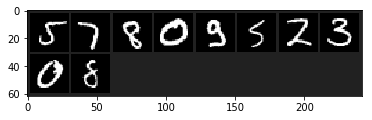

In [11]:
imshow(torchvision.utils.make_grid(images))

To feed into the MLP we will unroll the input as follows:

In [12]:
input_ = images.view(-1, 784)  # -1 tells PyTorch to infer the other dimensions, in this case just batch size
print(input_.size())

torch.Size([10, 784])


## Training for MNIST

Now we will define a generic training loop for the MLP which we can use for both MNIST and CIFAR-10. We will use cross-entropy loss and stochastic gradient descent with momentum.

In [13]:
def train_mlp(mlp, training_data, input_size, learning_rate, momentum, num_epochs):
    
    cross_entropy = nn.CrossEntropyLoss()
    optimiser = optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1} " + "="*80 + ">")
        
        total_loss = 0.0
        for batch_idx, batch in enumerate(training_data):
            images, labels = batch
            
            # zero accumulated gradients
            optimiser.zero_grad()
            
            # unroll images
            input_ = images.view(-1, input_size)
            # forward pass
            output = mlp(input_)
            # backward pass
            loss = cross_entropy(output, labels)
            loss.backward()
            optimiser.step()
            
            total_loss += loss.item()
            # print progress
            
            if (batch_idx + 1) % 1000 == 0:    # print every 1000 mini-batches
                print("[%4d/6000] loss: %.3f" %
                      (batch_idx + 1, total_loss / 1000))
                total_loss = 0.0
                
    print("Finished Training " + "="*71 + ">")

#### Now train

In [14]:
mnist_mlp = MLP(784, 280, 10)
print(mnist_mlp)

MLP(
  (hidden_layer): Linear(in_features=784, out_features=280, bias=True)
  (output_layer): Linear(in_features=280, out_features=10, bias=True)
)


In [15]:
train_mlp(mnist_mlp, mnist_trainloader, 784, learning_rate=0.001, momentum=0.9, num_epochs=3)

Epoch: 1 ================================================================================>
[1000/6000] loss: 0.598
[2000/6000] loss: 0.312
[3000/6000] loss: 0.256
[4000/6000] loss: 0.214
[5000/6000] loss: 0.198
[6000/6000] loss: 0.187
Epoch: 2 ================================================================================>
[1000/6000] loss: 0.152
[2000/6000] loss: 0.144
[3000/6000] loss: 0.144
[4000/6000] loss: 0.132
[5000/6000] loss: 0.116
[6000/6000] loss: 0.106
Epoch: 3 ================================================================================>
[1000/6000] loss: 0.099
[2000/6000] loss: 0.106
[3000/6000] loss: 0.091
[4000/6000] loss: 0.081
[5000/6000] loss: 0.088
[6000/6000] loss: 0.085
Finished Training =======================================================================>


## Evaluating on MNIST

Now we will evaluate the MLP - this will be useful for comparing it with other more sophisticated models.

Once again we will start by getting a visual feel for how the model compares to the groundtruth labels.

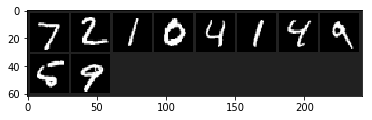

Groundtruth:      7     2     1     0     4     1     4     9     5     9


In [16]:
data_iter = iter(mnist_testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [17]:
input_ = images.view(-1, 784)
outputs = mnist_mlp(input_)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(10)))

Predicted:      7     2     1     0     4     1     4     9     6     9


In [18]:
def evaluate_mlp(mlp, test_data, input_size):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            images, truth = data
            input_ = images.view(-1, input_size)
            output = mlp(input_)
            _, predicted = torch.max(outputs.data, 1)
            total += truth.size(0)
            correct += (predicted == truth).sum().item()

    print('Accuracy of a simple MLP on the 10000 test images: %d %%' % (100 * correct / total))

In [19]:
evaluate_mlp(mnist_mlp, mnist_testloader, 784)

Accuracy of a simple MLP on the 10000 test images: 10 %


## CIFAR-10

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is an alternative benchmark (as a research sanity check) dataset to MNIST with the roughly the same size and resolution. The difference is that the images are 3-channel RGB images, so the dimensionality is much higher, and there is somewhat greater variation across classes and within classes in the dataset. This makes CIFAR-10 a harder classification task.

As with MNIST, we start by specifying our dataloaders.

In [20]:
cifar10_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  
                )   # note that we normalise over all channels

cifar10_trainset = torchvision.datasets.CIFAR10(root=CIFAR10, train=True, download=True, transform=cifar10_transforms)
cifar10_testset = torchvision.datasets.CIFAR10(root=CIFAR10, train=False, transform=cifar10_transforms)

Files already downloaded and verified


In [21]:
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=10, shuffle=True, num_workers=2)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=10, shuffle=False, num_workers=2)

In [22]:
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Data Preview

Once again it is worthwhile getting a feel for the CIFAR-10 image data as images and as tensors!

CIFAR-10 images are `32x32` RGB images. To feed them as input to an MLP, we need to unroll each image into a 32\*32\*3 = 3072 long vector. Note that we unroll over the three colour channels as well.

In [23]:
data_iter = iter(cifar10_trainloader)
images, labels = next(data_iter)  # remember that the batch size is 10, so this will contain 10 images

print(images.size())

torch.Size([10, 3, 32, 32])


We will modify the following helper function for CIFAR-10 images:

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

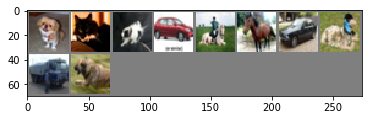

  dog   cat   dog   car horse horse   car  bird truck   dog


In [26]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(10)))

To feed into the MLP we will unroll the input as follows:

In [27]:
input_ = images.view(-1, 3072)  # -1 tells PyTorch to infer the other dimensions, in this case just batch size
print(input_.size())

torch.Size([10, 3072])


## Training for CIFAR-10

We will use the generic training loop defined earlier, only using a model with dimensions chosen to fit CIFAR-10. 

#### Now train

In [28]:
cifar10_mlp = MLP(3072, 512, 10)
print(cifar10_mlp)

MLP(
  (hidden_layer): Linear(in_features=3072, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=10, bias=True)
)


In [29]:
train_mlp(cifar10_mlp, cifar10_trainloader, 3072, learning_rate=0.001, momentum=0.9, num_epochs=3)

Epoch: 1 ================================================================================>
[1000/6000] loss: 1.864
[2000/6000] loss: 1.682
[3000/6000] loss: 1.631
[4000/6000] loss: 1.571
[5000/6000] loss: 1.539
Epoch: 2 ================================================================================>
[1000/6000] loss: 1.479
[2000/6000] loss: 1.435
[3000/6000] loss: 1.458
[4000/6000] loss: 1.429
[5000/6000] loss: 1.425
Epoch: 3 ================================================================================>
[1000/6000] loss: 1.352
[2000/6000] loss: 1.346
[3000/6000] loss: 1.337
[4000/6000] loss: 1.344
[5000/6000] loss: 1.360
Finished Training =======================================================================>


## Evaluating on CIFAR-10

Once again let's get a visual feel for how the model compares to the groundtruth.

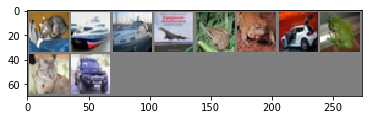

Groundtruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car


In [32]:
data_iter = iter(cifar10_testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join('%5s' % cifar10_classes[labels[j]] for j in range(10)))

In [33]:
input_ = images.view(-1, 3072)
outputs = cifar10_mlp(input_)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % cifar10_classes[predicted[j]] for j in range(10)))

Predicted:    cat  ship plane  ship  deer  frog   car  frog   dog   car


On the first batch the predictions don't appear too bad - remember that CIFAR-10 is a harder task than MNIST!

Using the evaluation function from earlier on the whole test set:

In [34]:
evaluate_mlp(cifar10_mlp, cifar10_testloader, 3072)

Accuracy of a simple MLP on the 10000 test images: 10 %


Again we do not do so well - this is not an issue as there are far more power modelling techniques available to us with much greater expressive power, especially for vision tasks). These will be explored in future notebooks.